In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from math import exp, expm1

There are some fundamental questions to resolve in this notebook before you move on.

- Which province has the highest average price? How about of those with at least 10 wines?
- Does the number of points predict the price of the wine? If so, how strong is the correlation?
- Dig into reviewer-level trends. Do reviewers tend to specialize in one or two provinces? Do they specialize in certain varieties?
- Dig into the 'description' column. What are some of the most common terms used in positive reviews? Negative reviews?

In [2]:
wine_tasting = pd.read_csv('C:/Users/hamza/Downloads/Springboard Case Studies/Capstone Project 3/winemag-data-130k-v2.csv')

In [3]:
wine_tasting = wine_tasting.set_index('id')
wine_tasting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [4]:
wine_tasting.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
id,,,,,,,,,,,,,
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Number Of Missing Values By Column

In [5]:
missing = pd.concat([wine_tasting.isnull().sum(), 100 * wine_tasting.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
description,0,0.000000
points,0,0.000000
title,0,0.000000
winery,0,0.000000
variety,1,0.000769
country,63,0.048472
province,63,0.048472
price,8996,6.921544
region_1,21247,16.347493
taster_name,26244,20.192197


`region_2` has the most missing values, at just over 60%. Also missing quite a few, the price is missing ~6% of values. The `isnull()` is not the only indicator of missing data. Sometimes 'missingness' can be encoded, perhaps by a -1 or 999. Such values are typically chosen because they are "obviously" not genuine values. If you were capturing data on people's heights and weights but missing someone's height, you could certainly encode that as a 0 because no one has a height of zero (in any units). Yet such entries would not be revealed by `isnull()`. Here, a data dictionary is needed to spot such values as part of looking for outliers. Someone with a height of zero should definitely show up as an outlier!

In [6]:
wine_tasting.drop(columns='region_2', inplace=True)

The above column had upwards of 60% of missing data, as such it will be dropped

In [7]:
wine_tasting.select_dtypes('object').head()

,country,description,designation,province,region_1,taster_name,taster_twitter_handle,title,variety,winery
id,,,,,,,,,,
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,Douro,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,Michigan,Lake Michigan Shore,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [8]:
wine_tasting.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


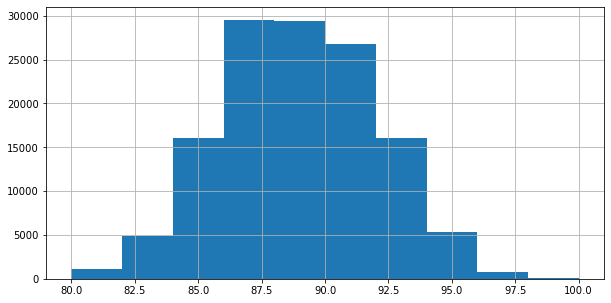

In [9]:
wine_tasting.points.hist(figsize=(10,5))
plt.subplots_adjust(hspace=.5)

In [10]:
wine_tasting.price.max()

3300.0

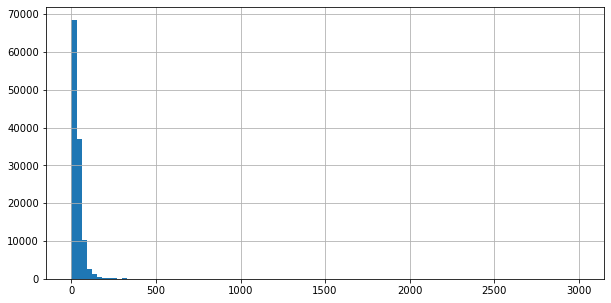

In [11]:
wine_tasting.price.hist(figsize=(10,5),bins=100,range=[0, 3000])
plt.subplots_adjust(hspace=.5)

In [13]:
wine_tasting[['country']].nunique()

country    43
dtype: int64

In [15]:
wine_tasting.head()

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,variety,winery
id,,,,,,,,,,,,
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [25]:
wine_tasting_means = wine_tasting.groupby('title')[['price','points']].mean()
wine_tasting_means.head(10)

,price,points
title,,
1+1=3 2008 Rosé Cabernet Sauvignon (Penedès),18.0,82.0
1+1=3 NV Brut Sparkling (Cava),16.0,87.0
1+1=3 NV Cygnus Brut Nature Reserva Made With Organic Grapes Sparkling (Cava),20.0,89.0
1+1=3 NV Rosé Sparkling (Cava),20.0,86.0
10 Knots 2006 Beachcomber White (Paso Robles),21.0,83.0
10 Knots 2006 Chardonnay (Santa Barbara County),21.0,85.0
10 Knots 2009 Moonraker Grenache (Paso Robles),35.0,81.0
10 Knots 2010 Viognier (Paso Robles),22.0,84.0
100 Percent Wine 2012 All Profits to Charity Red (California),18.0,89.0


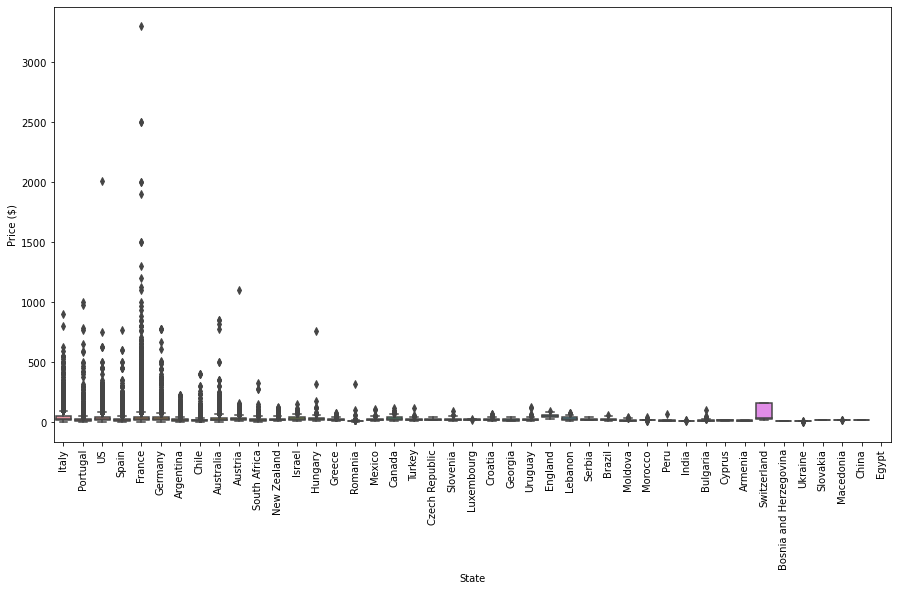

In [28]:
plt.subplots(figsize=(15, 8))
sns.boxplot(x='country', y='price', data=wine_tasting)
plt.xticks(rotation='vertical')
plt.ylabel('Price ($)')
plt.xlabel('State');